In [1]:
from google.colab import files
uploaded = files.upload()

Saving survey.csv to survey (1).csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import io

Datacsv = pd.read_csv(io.BytesIO(uploaded['survey.csv']),',',error_bad_lines=False)
Datadf = pd.DataFrame(Datacsv)
fdata = np.array(Datadf)
random.shuffle(fdata)
print(fdata.shape)
print(Datadf.describe(include = 'all'))

(1259, 27)
                  Timestamp  ...                         comments
count                  1259  ...                              164
unique                 1246  ...                              160
top     2014-08-27 15:24:47  ...  * Small family business - YMMV.
freq                      2  ...                                5
mean                    NaN  ...                              NaN
std                     NaN  ...                              NaN
min                     NaN  ...                              NaN
25%                     NaN  ...                              NaN
50%                     NaN  ...                              NaN
75%                     NaN  ...                              NaN
max                     NaN  ...                              NaN

[11 rows x 27 columns]


In [3]:
Datadf.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [0]:
Datadf = Datadf.drop(['comments'], axis= 1)
Datadf = Datadf.drop(['state'], axis= 1)
Datadf = Datadf.drop(['Timestamp'], axis= 1)

In [0]:
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# Clean the NaN's
for feature in Datadf:
    if feature in intFeatures:
        Datadf[feature] = Datadf[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        Datadf[feature] = Datadf[feature].fillna(defaultString)
    elif feature in floatFeatures:
        Datadf[feature] = Datadf[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)

In [6]:
Datadf['Age'].fillna(0)
print(Datadf['Gender'].unique())
gender = Datadf['Gender'].str.lower()
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in Datadf.iterrows():

    if str.lower(col.Gender) in male_str:
        Datadf['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        Datadf['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        Datadf['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#Get rid of bullshit
stk_list = ['A little about you', 'p']
Datadf = Datadf[~Datadf['Gender'].isin(stk_list)]



['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous' 'Male '
 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means']


In [0]:
Datadf['Age'].fillna(Datadf['Age'].median(), inplace = True)

# Fill with media() values < 18 and > 120
s = pd.Series(Datadf['Age'])
s[s<18] = Datadf['Age'].median()
Datadf['Age'] = s
s = pd.Series(Datadf['Age'])
s[s>120] = Datadf['Age'].median()
Datadf['Age'] = s

#Ranges of Age
Datadf['age_range'] = pd.cut(Datadf['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

In [8]:
defaultString = 'NaN'
Datadf['self_employed'] = Datadf['self_employed'].replace([defaultString], 'No')
print(Datadf['self_employed'].unique())
Datadf['work_interfere'] = Datadf['work_interfere'].replace([defaultString], 'Don\'t know' )
print(Datadf['work_interfere'].unique())

['No' 'Yes']
['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


In [9]:
MDATA = Datadf[['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere','treatment']]
MDATA.head()

,Age,Gender,family_history,benefits,care_options,anonymity,leave,work_interfere,treatment
0,37,female,No,Yes,Not sure,Yes,Somewhat easy,Often,Yes
1,44,male,No,Don't know,No,Don't know,Don't know,Rarely,No
2,32,male,No,No,No,Don't know,Somewhat difficult,Rarely,No
3,31,male,Yes,No,Yes,No,Somewhat difficult,Often,Yes
4,31,male,No,Yes,No,Don't know,Don't know,Never,No


In [10]:

labelDict = {}
for feature in Datadf:
    le = preprocessing.LabelEncoder()
    le.fit(Datadf[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    Datadf[feature] = le.transform(Datadf[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

print(Datadf.head())
print(Datadf.describe(include='all'))

label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

In [12]:
Datadf = Datadf.drop(['Country'], axis= 1)
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler
scaler = MinMaxScaler()
Datadf['Age'] = scaler.fit_transform(Datadf[['Age']])
Datadf.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,1,1,2,2,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,0,1,1,0,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,2,1,1,1,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,0,0,0,0,0,1,1,1,2,2,2,0,0,2


In [0]:
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = Datadf[feature_cols]
y = Datadf.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [0]:
from feature_selector import FeatureSelector
fs = FeatureSelector(data = X, labels = y)

In [23]:
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)

zero_importance_features = fs.ops['zero_importance']

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[28]	valid_0's auc: 0.881508
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[22]	valid_0's auc: 0.869365
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[40]	valid_0's auc: 0.907329
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[33]	valid_0's auc: 0.89944
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[33]	valid_0's auc: 0.90084
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's auc: 0.86101
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	valid_0's auc: 0.910633
Training until validation scores don't improve for 100 rounds.
Early stopping, b

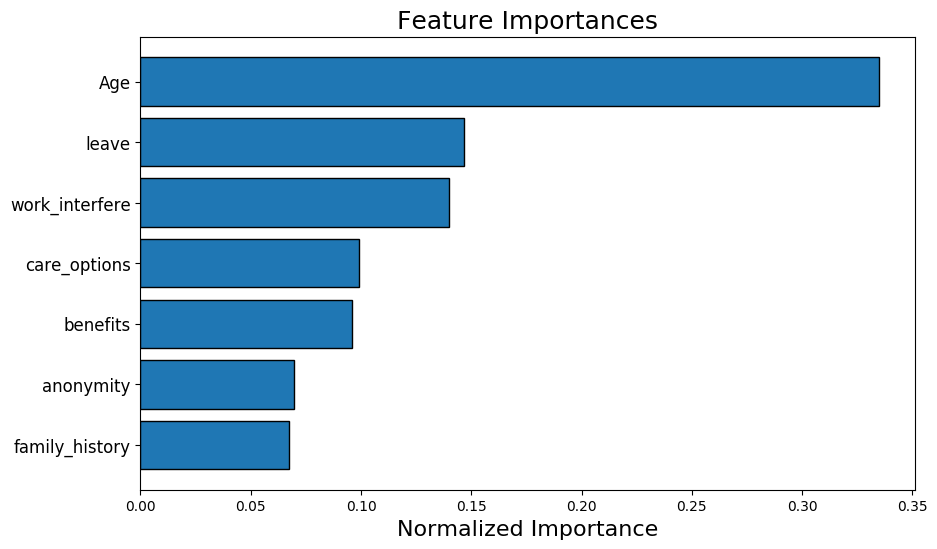

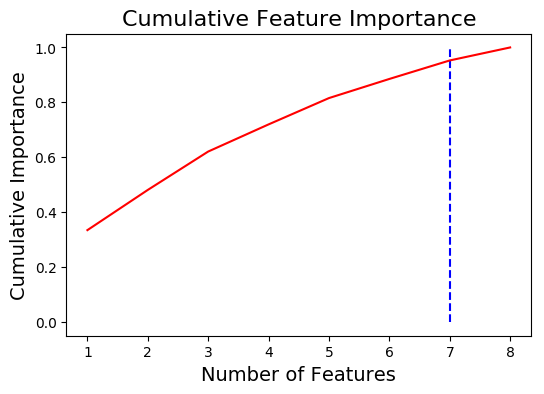

7 features required for 0.90 of cumulative importance


In [25]:
fs.plot_feature_importances(threshold = 0.90, plot_n = 22)

In [26]:
fs.identify_low_importance(cumulative_importance = 0.90)

6 features required for cumulative importance of 0.90 after one hot encoding.
2 features do not contribute to cumulative importance of 0.90.



In [27]:
fs.feature_importances

,feature,importance,normalized_importance,cumulative_importance
0,Age,415.6,0.334622,0.334622
1,leave,181.9,0.146457,0.481079
2,work_interfere,173.6,0.139775,0.620853
3,care_options,122.8,0.098873,0.719726
4,benefits,119.1,0.095894,0.815620
5,anonymity,86.5,0.069646,0.885266
6,family_history,83.7,0.067391,0.952657
7,Gender,58.8,0.047343,1.000000


In [28]:
train_removed = fs.remove(methods = 'all')
train_removed.head()

['zero_importance', 'low_importance'] methods have been run

Removed 2 features.


,Age,benefits,care_options,anonymity,leave,work_interfere
0,0.431818,2,1,2,2,2
1,0.590909,0,0,0,0,3
2,0.318182,1,0,0,1,3
3,0.295455,1,2,1,1,2
4,0.295455,2,0,0,0,1


In [42]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy

numpy.random.seed(7)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
model = Sequential()
model.add(Dense(60, input_dim=8, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0)
scores = model.evaluate(X_test, y_test, verbose=0)
cvscores.append(scores[1] * 100)
print("%.2f%%" % (numpy.mean(cvscores)))

82.14%


In [45]:
X_Predict = np.array([[0.159091,	1,	1,	0,	1,	0,	4,	4]])
ynew = model.predict_classes(X_Predict)
ynew1 = model.predict_proba(X_Predict)
print("X=%s, Predicted=%s" % (X_Predict[0], ynew[0]))
print("X=%s, Predicted=%s" % (X_Predict[0], ynew1[0])) #probability of instance belonging to class 1

X=[0.159091 1.       1.       0.       1.       0.       4.       4.      ], Predicted=[1]
X=[0.159091 1.       1.       0.       1.       0.       4.       4.      ], Predicted=[0.66956806]
